In [1]:
import os
import librosa
import numpy as np
import time
import joblib
from sklearn.metrics import accuracy_score
import librosa.display
import scipy.fftpack as fftpack
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


In [2]:
train_path = 'E:/Queenless/archive/nuhive_processed/train'
val_path = 'E:/Queenless/archive/nuhive_processed/val'
test_path = 'E:/Queenless/archive/nuhive_processed/test'

output_dir = 'E:/Queenless/kaggle_features'
os.makedirs(output_dir, exist_ok=True)

# MFCCs

In [3]:
def pre_emphasis(signal_in, alpha=0.97):
    """
    Bước 1: Pre-emphasis - Lọc thông cao
    """
    emphasized_signal = np.append(signal_in[0], signal_in[1:] - alpha * signal_in[:-1]) # y(t) = x(t) - alpha*x(t-1)
    return emphasized_signal

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Bước 2: Chia khung (Framing)
    - frame_size: kích thước khung (số giây)
    - frame_stride: bước nhảy giữa các khung (số giây)
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    # Zero-padding nếu cần
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Bước 3: Áp dụng cửa sổ Hamming cho mỗi khung
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    windowed_frames = frames * hamming
    return windowed_frames

def fft_frames(frames, NFFT=512):
    """
    Bước 4: Tính FFT cho mỗi khung
    """
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    return mag_frames

def power_spectrum(mag_frames, NFFT=512):
    """
    Bước 4.1: Tính phổ công suất của mỗi khung
    """
    return (1.0 / NFFT) * (mag_frames ** 2)

def mel_filterbank(sample_rate, NFFT, nfilt=26, low_freq=0, high_freq=None):
    """
    Bước 5: Tạo Mel filterbank
    """
    if high_freq is None:
        high_freq = sample_rate / 2

    # Chuyển Hz sang Mel
    low_mel = 2595 * np.log10(1 + low_freq / 700.0)
    high_mel = 2595 * np.log10(1 + high_freq / 700.0)
    mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
    # Chuyển lại từ Mel sang Hz
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # giới hạn trái
        f_m = int(bin[m])             # trung tâm
        f_m_plus = int(bin[m + 1])    # giới hạn phải

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank

# Hàm tính mfccs
def compute_mfccs(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, 
                 pre_emph=0.97, NFFT=512, nfilt=26, num_ceps=13):
    emphasized_signal = pre_emphasis(signal_in, pre_emph)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    pow_frames = power_spectrum(mag_frames, NFFT)
    fbank = mel_filterbank(sample_rate, NFFT, nfilt)
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    log_fbank = np.log(filter_banks)
    mfccs = fftpack.dct(log_fbank, type=2, axis=1, norm='ortho')[:, :num_ceps]
    return mfccs

In [4]:

def extract_mfccs_features(directory, sample_rate=22050, output_dir=None, dataset_type='train'):
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'mfccs_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'mfccs_labels_{dataset_type}.pkl')
    data_file = os.path.join(output_dir, f'mfccs_data_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file) and os.path.exists(data_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
        data = joblib.load(data_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        data = []  # Thêm một biến để lưu dữ liệu đầu vào (có thể là tín hiệu, ví dụ như signal hoặc các thông tin khác)
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                mfccs = compute_mfccs(signal_in=signal, sample_rate=sr)
                mfccs_mean = np.mean(mfccs, axis=0)
                features.append(mfccs_mean)
                labels.append(label)
                data.append(signal)  # Lưu tín hiệu âm thanh gốc hoặc dữ liệu khác nếu cần
        
        features = np.array(features)
        labels = np.array(labels)
        data = np.array(data)  # Chuyển dữ liệu sang dạng numpy array nếu cần lưu
        
        if output_dir:
            # Lưu từng đối tượng riêng biệt cho train/val/test
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
            joblib.dump(data, data_file)  # Lưu tín hiệu âm thanh hoặc dữ liệu
        
        end_time = time.time()
        print(f"MFCCs extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels, data

train_features_mfccs, train_labels_mfccs, train_data_mfccs = extract_mfccs_features(train_path, output_dir=output_dir, dataset_type='train')
val_features_mfccs, val_labels_mfccs, val_data_mfccs = extract_mfccs_features(val_path, output_dir=output_dir, dataset_type='val')
test_features_mfccs, test_labels_mfccs, test_data_mfccs = extract_mfccs_features(test_path, output_dir=output_dir, dataset_type='test')

train_features_mfccs = np.vstack((train_features_mfccs, val_features_mfccs))
train_labels_mfccs = np.hstack((train_labels_mfccs, val_labels_mfccs))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [5]:
print(train_features_mfccs.shape)
print(test_features_mfccs.shape)

(11032, 13)
(2760, 13)


In [6]:
train_features_mfccs[0, :]

array([-7.69012215e+01, -6.49288160e+00, -5.74182178e-01, -1.52679723e+00,
       -5.43324555e-01, -1.29329803e+00, -1.18185219e+00, -2.59659006e-01,
        3.90794469e-04, -1.42850865e-01, -2.83489472e-01, -3.32329969e-01,
       -1.84998776e-01])

In [7]:
scaler = StandardScaler()
train_features_mfccs_scaled = scaler.fit_transform(train_features_mfccs)
test_features_mfccs_scaled = scaler.transform(test_features_mfccs)

MFCCs - RF

In [8]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
rf_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_predictions = rf_classifier.predict(test_features_mfccs_scaled)
test_accuracy_mfccs_rf = accuracy_score(test_labels_mfccs, test_predictions)
print(f"Test Accuracy: {test_accuracy_mfccs_rf * 100:.2f}%")


Training time: 8.23 seconds
Test Accuracy: 85.40%


Tuning bootstrap=False from 92% to 92.38%

MFCCs - SVM

In [9]:
start_time = time.time()

svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma=1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_svm = accuracy_score(test_labels_mfccs, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_mfccs_svm * 100:.2f}%")

Training time: 6.90 seconds
Test Accuracy (SVM with RBF Kernel): 84.96%


In [10]:
start_time = time.time()

# Khởi tạo mô hình SVM với data scaling
svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma=1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_svm = accuracy_score(test_labels_mfccs, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_mfccs_svm * 100:.2f}%")

Training time: 7.44 seconds
Test Accuracy (SVM with RBF Kernel): 85.11%


Scaling data improve from 94% to 94.05%

MFCCs - LR

In [11]:
start_time = time.time()

# Khởi tạo mô hình Logistic Regression
lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='liblinear', max_iter=100, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# Huấn luyện mô hình Logistic Regression với dữ liệu đã chuẩn hóa
lr_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_lr = lr_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_lr = accuracy_score(test_labels_mfccs, test_predictions_lr)
print(f"Test Accuracy (Logistic Regression): {test_accuracy_mfccs_lr * 100:.2f}%")

Training time: 0.16 seconds
Test Accuracy (Logistic Regression): 68.37%


In [12]:
start_time = time.time()

# Khởi tạo mô hình Logistic Regression với data scaling
lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='liblinear', max_iter=100, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# Huấn luyện mô hình Logistic Regression với dữ liệu đã chuẩn hóa
lr_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_lr = lr_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_lr = accuracy_score(test_labels_mfccs, test_predictions_lr)
print(f"Test Accuracy (Logistic Regression): {scale_test_accuracy_mfccs_lr * 100:.2f}%")

Training time: 0.10 seconds
Test Accuracy (Logistic Regression): 68.33%


Tuned the LR model but still only has 73.28% accuracy -> problem with feature extraction method?

MFCCs - ET

In [13]:
start_time = time.time()

# Khởi tạo mô hình Extra Trees 
et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_et = accuracy_score(test_labels_mfccs, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_mfccs_et * 100:.2f}%")


Training time: 5.43 seconds
Test Accuracy (Extra Trees): 85.43%


In [14]:
start_time = time.time()

# Khởi tạo mô hình Extra Trees với data scaling
et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_et = accuracy_score(test_labels_mfccs, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_mfccs_et * 100:.2f}%")


Training time: 5.67 seconds
Test Accuracy (Extra Trees): 85.51%


Model tuning improved from 92.53% to 92.97%

MFCCs - KNN

In [15]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

# Huấn luyện mô hình KNN với dữ liệu đã chuẩn hóa
knn_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_knn = knn_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_knn = accuracy_score(test_labels_mfccs, test_predictions_knn)
print(f"Test Accuracy (KNN): {test_accuracy_mfccs_knn * 100:.2f}%")

Training time: 0.03 seconds
Test Accuracy (KNN): 85.00%


In [16]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

# Huấn luyện mô hình KNN với dữ liệu đã chuẩn hóa
knn_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_knn = knn_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_knn = accuracy_score(test_labels_mfccs, test_predictions_knn)
print(f"Test Accuracy (KNN): {scale_test_accuracy_mfccs_knn * 100:.2f}%")

Training time: 0.02 seconds
Test Accuracy (KNN): 83.59%


# FFTs (with pre-emphasis, framing, windowing)

In [17]:
def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Chia tín hiệu thành các frame có kích thước và bước nhảy xác định.
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Áp dụng cửa sổ Hamming cho mỗi frame.
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    return frames * hamming

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, apply_log=True):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      - (Tùy chọn) Áp dụng log để giảm phạm vi giá trị.
      
    Trả về: vector đặc trưng có kích thước (NFFT/2+1,).
    """
    emphasized_signal = pre_emphasis(signal_in)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    fft_feature = np.mean(mag_frames, axis=0)  # Trung bình theo các frame
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    return fft_feature


In [18]:
def load_fft_features_from_directory(directory, sample_rate=22050, NFFT=512, output_dir=None, dataset_type='train'):
    """
    Duyệt qua các file âm thanh trong thư mục và tính đặc trưng FFT cho mỗi file.
    Giả sử trong directory có hai thư mục con: 'Queen' và 'NonQueen'.
    
    Trả về:
      - features: mảng đặc trưng (mỗi đặc trưng có kích thước NFFT/2+1)
      - labels: nhãn tương ứng.
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'fft3_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'fft3_labels_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                fft_feature = compute_fft_features(signal, sr, NFFT=NFFT)
                features.append(fft_feature)
                labels.append(label)
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"FFT extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

In [19]:
train_features_fft, train_labels_fft = load_fft_features_from_directory(train_path, sample_rate=22050, NFFT=512, output_dir=output_dir, dataset_type='train')
val_features_fft, val_labels_fft = load_fft_features_from_directory(val_path, sample_rate=22050, NFFT=512, output_dir=output_dir, dataset_type='val')
test_features_fft, test_labels_fft = load_fft_features_from_directory(test_path, sample_rate=22050, NFFT=512, output_dir=output_dir, dataset_type='test')

train_features_fft = np.vstack((train_features_fft, val_features_fft))
train_labels_fft = np.hstack((train_labels_fft, val_labels_fft))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [20]:
scaler = StandardScaler()
train_features_fft_scaled = scaler.fit_transform(train_features_fft)
test_features_fft_scaled = scaler.transform(test_features_fft)

FFTs - KNN

In [21]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.01 seconds
KNN (FFT features) - Test Accuracy: 86.52%


94.25% to 95.15%, pre_emph = 0.98 => 95.28

In [22]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft_scaled)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.01 seconds
KNN (FFT features) - Test Accuracy: 85.18%


94.25%, pre_emph = 0.98 => 94.42

FFTs - SVM

In [23]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft)
test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_fft_svm * 100:.2f}%")

Training time: 9.19 seconds
Test Accuracy (SVM with RBF Kernel): 87.72%


97.47%

In [24]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft_scaled)
scale_test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_fft_svm * 100:.2f}%")

Training time: 11.59 seconds
Test Accuracy (SVM with RBF Kernel): 87.36%


97.82

FFTs - LR

In [25]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='lbfgs', max_iter=1500, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lr_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_lr = lr_classifier.predict(test_features_fft)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_lr)*100:.2f}%")


Training time: 5.23 seconds
Logistic Regression (FFT features) - Test Accuracy: 79.93%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='saga', max_iter=1000, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

scale_test_accuracy_fft_lr = lr_classifier.predict(test_features_fft_scaled)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, scale_test_accuracy_fft_lr)*100:.2f}%")


Training time: 92.75 seconds
Logistic Regression (FFT features) - Test Accuracy: 80.18%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tuning from 85.97% to 86.05%

Using min max scaling -> 86.08%

But Non-scaling data working better -> 86.33%

FFTs - RF

In [27]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                       n_jobs=None, random_state=42, verbose=0, warm_start=False, class_weight=None, 
                                       ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_rf = rf_classifier.predict(test_features_fft)
print(f"Random Forest (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_rf)*100:.2f}%")

Training time: 28.82 seconds
Random Forest (FFT features) - Test Accuracy: 84.38%


Not tuning yet

FFTs - ET

In [28]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft)
test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_fft_et * 100:.2f}%")


Training time: 84.08 seconds
Test Accuracy (Extra Trees): 86.59%


In [29]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft_scaled)
scale_test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_fft_et * 100:.2f}%")


Training time: 87.75 seconds
Test Accuracy (Extra Trees): 86.59%


93.95% -> 95.80% beautifull

# FFTs + MFCC

In [44]:
def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Chia tín hiệu thành các frame có kích thước và bước nhảy xác định.
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Áp dụng cửa sổ Hamming cho mỗi frame.
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    return frames * hamming

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, apply_log=True):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh.
    """
    emphasized_signal = pre_emphasis(signal_in)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    fft_feature = np.mean(mag_frames, axis=0)
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)
    return fft_feature

def compute_mfcc_features(signal_in, sample_rate, n_mfcc=13):
    """
    Tính toán đặc trưng MFCC cho tín hiệu âm thanh sử dụng thư viện librosa.
    """
    # Trích xuất MFCC sử dụng librosa
    mfccs = librosa.feature.mfcc(y=signal_in, sr=sample_rate, n_mfcc=n_mfcc)
    # Lấy trung bình theo các frame (theo thời gian)
    mfcc_features = np.mean(mfccs, axis=1)
    return mfcc_features

def compute_fft_mfcc(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, n_mfcc=13):
    """
    Kết hợp đặc trưng FFT và MFCC thành một vector duy nhất.
    
    Args:
        signal_in: Tín hiệu âm thanh đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame (giây)
        frame_stride: Bước nhảy giữa các frame (giây)
        NFFT: Kích thước FFT
        n_mfcc: Số lượng hệ số MFCC
        
    Returns:
        Vector đặc trưng kết hợp FFT và MFCC
    """
    # Tính toán đặc trưng FFT
    fft_features = compute_fft_features(signal_in, sample_rate, frame_size, frame_stride, NFFT)
    
    # Tính toán đặc trưng MFCC
    mfcc_features = compute_mfcc_features(signal_in, sample_rate, n_mfcc)
    
    # Kết hợp 2 đặc trưng
    fft_mfcc = np.concatenate((fft_features, mfcc_features))
    
    return fft_mfcc

def load_fft_mfcc_from_directory(directory, sample_rate=22050, NFFT=512, n_mfcc=13, 
                                       output_dir=None, dataset_type='train'):
    """
    Duyệt qua các file âm thanh trong thư mục và tính toán đặc trưng kết hợp (FFT + MFCC).
    
    Args:
        directory: Thư mục chứa file âm thanh
        sample_rate: Tần số lấy mẫu
        NFFT: Kích thước FFT
        n_mfcc: Số lượng hệ số MFCC
        output_dir: Thư mục lưu file đặc trưng
        dataset_type: Loại dữ liệu (train, val, test)
        
    Returns:
        features: Mảng đặc trưng kết hợp
        labels: Nhãn tương ứng
    """
    # Kiểm tra nếu file đã tồn tại
    features_file = os.path.join(output_dir, f'fft_mfcc_{dataset_type}2.pkl')
    labels_file = os.path.join(output_dir, f'fft_mfcc_labels_{dataset_type}2.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading combined {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting combined features for {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                
                # Tính toán đặc trưng kết hợp
                combined_feature = compute_fft_mfcc(signal, sr, NFFT=NFFT, n_mfcc=n_mfcc)
                
                features.append(combined_feature)
                labels.append(label)
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"Combined feature extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

In [45]:
train_fft_mfcc, train_fft_mfcc_labels = load_fft_mfcc_from_directory(
    train_path, sample_rate=22050, NFFT=512, n_mfcc=70, output_dir=output_dir, dataset_type='train')
val_fft_mfcc, val_fft_mfcc_labels = load_fft_mfcc_from_directory(
    val_path, sample_rate=22050, NFFT=512, n_mfcc=70, output_dir=output_dir, dataset_type='val')
test_fft_mfcc, test_fft_mfcc_labels = load_fft_mfcc_from_directory(
    test_path, sample_rate=22050, NFFT=512, n_mfcc=70, output_dir=output_dir, dataset_type='test')

train_fft_mfcc = np.vstack((train_fft_mfcc, val_fft_mfcc))
train_fft_mfcc_labels = np.hstack((train_fft_mfcc_labels, val_fft_mfcc_labels))


Loading combined train data from .pkl files...


Loading combined val data from .pkl files...
Loading combined test data from .pkl files...


In [46]:
print(f"Combined feature shape: {train_fft_mfcc.shape}")

Combined feature shape: (11032, 327)


In [47]:
scaler = StandardScaler()
train_fft_mfcc_scaled = scaler.fit_transform(train_fft_mfcc)
test_fft_mfcc_scaled = scaler.transform(test_fft_mfcc)

In [48]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
rf_classifier.fit(train_fft_mfcc_scaled, train_fft_mfcc_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_predictions = rf_classifier.predict(test_fft_mfcc_scaled)
test_accuracy_mfcc_rf = accuracy_score(test_fft_mfcc_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy_mfcc_rf * 100:.2f}%")


Training time: 51.47 seconds
Test Accuracy: 86.78%


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel

def get_feature_importance(rf_model, feature_names=None):
    """
    Extract feature importances from a trained Random Forest classifier
    
    Args:
        rf_model: Trained RandomForestClassifier model
        feature_names: Optional list of feature names
        
    Returns:
        DataFrame with feature names and importance scores, sorted by importance
    """
    # Get feature importances
    importances = rf_model.feature_importances_
    
    # Create feature names if not provided
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(len(importances))]
    
    # Create DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(
        by='Importance', ascending=False
    ).reset_index(drop=True)
    
    return feature_importance_df

def plot_feature_importance(importance_df, top_n=20, figsize=(12, 8)):
    """
    Plot the top N most important features
    
    Args:
        importance_df: DataFrame with feature importances
        top_n: Number of top features to plot
        figsize: Figure size (width, height)
    """
    # Get top N features
    plot_data = importance_df.head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x='Importance', y='Feature', data=plot_data)
    plt.title(f'Top {top_n} Feature Importance')
    plt.tight_layout()
    plt.show()

def select_top_features(X, rf_model, top_n=None, threshold=None):
    """
    Select top features based on importance from Random Forest model
    
    Args:
        X: Original feature matrix
        rf_model: Trained RandomForestClassifier model
        top_n: Number of top features to select (optional)
        threshold: Minimum importance threshold (optional)
        
    Returns:
        X_reduced: Feature matrix with only selected features
        selected_indices: Indices of selected features
    """
    if top_n is not None:
        # Get indices of top N features
        indices = np.argsort(rf_model.feature_importances_)[::-1][:top_n]
        X_reduced = X[:, indices]
        return X_reduced, indices
    
    elif threshold is not None:
        # Use scikit-learn's SelectFromModel
        sfm = SelectFromModel(rf_model, threshold=threshold)
        X_reduced = sfm.fit_transform(X, None)
        selected_indices = np.where(sfm.get_support())[0]
        return X_reduced, selected_indices
    
    else:
        raise ValueError("Either top_n or threshold must be specified")

# Example usage (add this to your code)
def analyze_feature_importance(rf_classifier, X_train, X_test, train_labels, test_labels, 
                              n_features_to_select=100):
    """
    Analyze feature importance, select top features and evaluate model performance
    
    Args:
        rf_classifier: Trained RandomForestClassifier model
        X_train: Training feature matrix
        X_test: Testing feature matrix
        train_labels: Training labels
        test_labels: Testing labels
        n_features_to_select: Number of top features to select
        
    Returns:
        top_features_df: DataFrame with top features and their importance
        X_train_reduced: Reduced training feature matrix
        X_test_reduced: Reduced testing feature matrix
        selected_indices: Indices of selected features
    """
    # Generate feature names (assuming combined FFT and MFCC features)
    n_features = X_train.shape[1]
    n_fft = n_features - 70  # Assuming 70 MFCC features as per your code
    feature_names = [f"FFT_{i}" for i in range(n_fft)]
    feature_names.extend([f"MFCC_{i}" for i in range(70)])
    
    # Get and plot feature importance
    importance_df = get_feature_importance(rf_classifier, feature_names)
    plot_feature_importance(importance_df, top_n=20)
    
    # Select top features
    X_train_reduced, selected_indices = select_top_features(
        X_train, rf_classifier, top_n=n_features_to_select
    )
    X_test_reduced = X_test[:, selected_indices]
    
    # Train a new model with reduced features
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    
    rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False)
    rf_reduced.fit(X_train_reduced, train_labels)
    
    # Evaluate
    test_pred_reduced = rf_reduced.predict(X_test_reduced)
    test_accuracy_reduced = accuracy_score(test_labels, test_pred_reduced)
    
    print(f"Original model features: {n_features}")
    print(f"Reduced model features: {n_features_to_select}")
    print(f"Reduced model test accuracy: {test_accuracy_reduced * 100:.2f}%")
    
    return importance_df, X_train_reduced, X_test_reduced, selected_indices

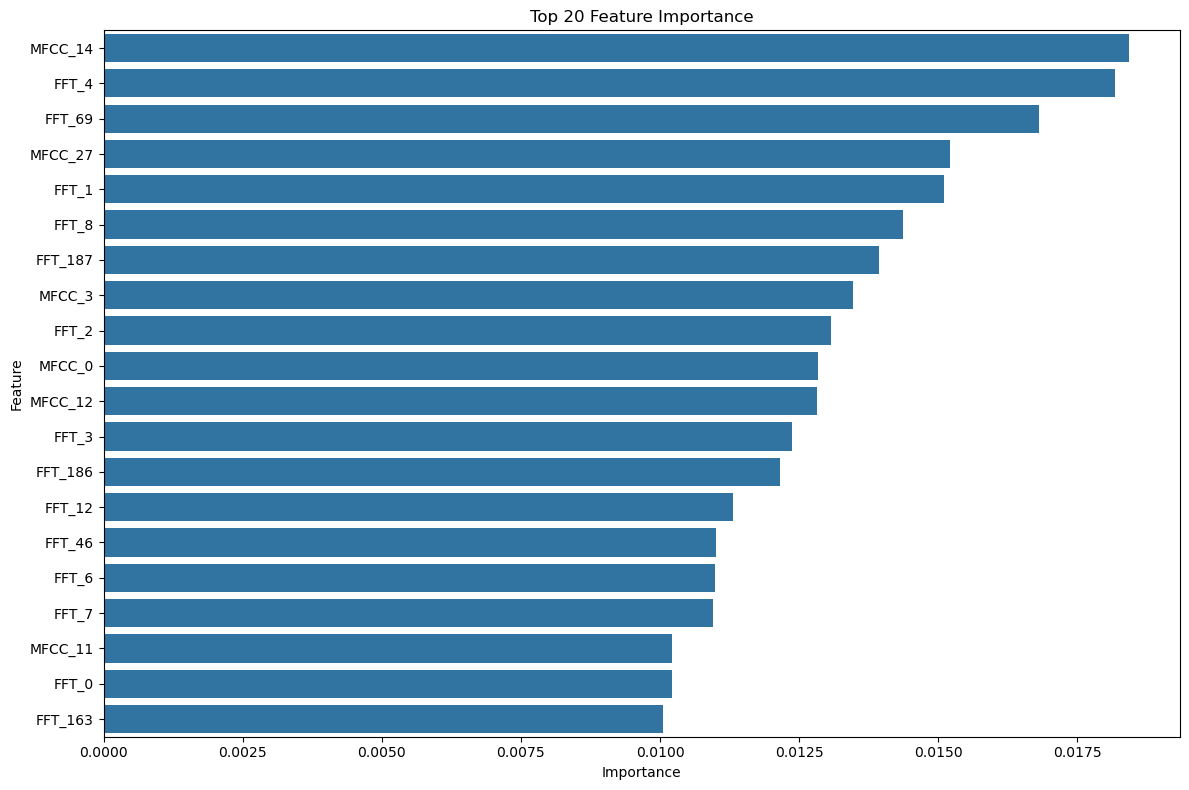

Original model features: 327
Reduced model features: 200
Reduced model test accuracy: 87.36%
Top 10 most important features:
   Feature  Importance
0  MFCC_14    0.018421
1    FFT_4    0.018178
2   FFT_69    0.016804
3  MFCC_27    0.015205
4    FFT_1    0.015100
5    FFT_8    0.014367
6  FFT_187    0.013932
7   MFCC_3    0.013469
8    FFT_2    0.013074
9   MFCC_0    0.012829

Classification Report for Optimized Model:
              precision    recall  f1-score   support

         bee       0.89      0.96      0.92      1095
       nobee       0.85      0.61      0.71       692
     noqueen       0.86      0.97      0.91       973

    accuracy                           0.87      2760
   macro avg       0.87      0.84      0.85      2760
weighted avg       0.87      0.87      0.87      2760



In [52]:
# After training your Random Forest model, analyze feature importance
importance_df, train_reduced, test_reduced, selected_indices = analyze_feature_importance(
    rf_classifier,
    train_fft_mfcc_scaled,
    test_fft_mfcc_scaled,
    train_fft_mfcc_labels,
    test_fft_mfcc_labels,
    n_features_to_select=200  # Select top 100 features
)

# Save the important features for future use
top_features_file = os.path.join(output_dir, 'top_features.pkl')
joblib.dump({
    'importance_df': importance_df,
    'selected_indices': selected_indices
}, top_features_file)

print("Top 10 most important features:")
print(importance_df.head(10))

# Optional: Train a new model with only the most important features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_optimized = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini',
    bootstrap=False,
    random_state=42
)

rf_optimized.fit(train_reduced, train_fft_mfcc_labels)
test_pred_optimized = rf_optimized.predict(test_reduced)

print("\nClassification Report for Optimized Model:")
print(classification_report(test_fft_mfcc_labels, test_pred_optimized))

87.07

In [53]:
start_time = time.time()

# Khởi tạo mô hình Logistic Regression với data scaling
lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='liblinear', max_iter=100, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# Huấn luyện mô hình Logistic Regression với dữ liệu đã chuẩn hóa
lr_classifier.fit(train_fft_mfcc_scaled, train_fft_mfcc_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_lr = lr_classifier.predict(test_fft_mfcc_scaled)
scale_test_accuracy_mfcc_lr = accuracy_score(test_fft_mfcc_labels, test_predictions_lr)
print(f"Test Accuracy (Logistic Regression): {scale_test_accuracy_mfcc_lr * 100:.2f}%")

Training time: 14.23 seconds
Test Accuracy (Logistic Regression): 81.20%


In [54]:
start_time = time.time()

# Khởi tạo mô hình Extra Trees 
et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier.fit(train_fft_mfcc, train_fft_mfcc_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_fft_mfcc)
test_accuracy_mfcc_et = accuracy_score(test_fft_mfcc_labels, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_mfcc_et * 100:.2f}%")


Training time: 113.87 seconds
Test Accuracy (Extra Trees): 87.83%


In [55]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

# Huấn luyện mô hình KNN với dữ liệu đã chuẩn hóa
knn_classifier.fit(train_fft_mfcc_scaled, train_fft_mfcc_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_knn = knn_classifier.predict(test_fft_mfcc_scaled)
scale_test_accuracy_mfcc_knn = accuracy_score(test_fft_mfcc_labels, test_predictions_knn)
print(f"Test Accuracy (KNN): {scale_test_accuracy_mfcc_knn * 100:.2f}%")

Training time: 0.02 seconds
Test Accuracy (KNN): 87.21%


In [56]:
start_time = time.time()

svm_rbf_classifier = SVC(C=8.31, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_fft_mfcc_scaled, train_fft_mfcc_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_fft_mfcc_scaled)
scale_test_accuracy_mfcc_svm = accuracy_score(test_fft_mfcc_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_mfcc_svm * 100:.2f}%")

Training time: 7.35 seconds
Test Accuracy (SVM with RBF Kernel): 86.30%


# MFCC

In [57]:
def compute_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, dct_type=2, norm='ortho', lifter=0)
    return mfcc

In [58]:
def extract_mfcc_features(directory, sample_rate=22050, output_dir=None, dataset_type='train', reduce_dimension=True):
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'mfcc2_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'mfcc2_labels_{dataset_type}.pkl')
    data_file = os.path.join(output_dir, f'mfcc2_data_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file) and os.path.exists(data_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
        data = joblib.load(data_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        data = []  # Thêm một biến để lưu dữ liệu đầu vào (có thể là tín hiệu, ví dụ như signal hoặc các thông tin khác)
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                mfcc = compute_mfcc(file_path=file_path, n_mfcc=70)  # Chiết xuất MFCC cho mỗi tệp âm thanh
                features.append(mfcc)  # Lưu ma trận MFCC cho mỗi tệp âm thanh
                labels.append(label)
        
        features = np.array(features)
        labels = np.array(labels)
        data = np.array(data)  # Chuyển dữ liệu sang dạng numpy array nếu cần lưu
        
        # Nếu cần giảm chiều theo axis=2
        if reduce_dimension:
            features = np.mean(features, axis=2)
        
        if output_dir:
            # Lưu từng đối tượng riêng biệt cho train/val/test
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
            joblib.dump(data, data_file)  # Lưu tín hiệu âm thanh hoặc dữ liệu
        
        end_time = time.time()
        print(f"MFCC extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels, data

# Gọi hàm với tham số reduce_dimension=True để giảm chiều ngay khi gọi hàm
train_features_mfcc, train_labels_mfcc, train_data_mfcc = extract_mfcc_features(train_path, output_dir=output_dir, dataset_type='train')
val_features_mfcc, val_labels_mfcc, val_data_mfcc = extract_mfcc_features(val_path, output_dir=output_dir, dataset_type='val')
test_features_mfcc, test_labels_mfcc, test_data_mfcc = extract_mfcc_features(test_path, output_dir=output_dir, dataset_type='test')

train_features_mfcc = np.vstack((train_features_mfcc, val_features_mfcc))
train_labels_mfcc = np.hstack((train_labels_mfcc, val_labels_mfcc))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [59]:
train_features_mfcc.shape

(11032, 70)

In [60]:
scaler = StandardScaler()
train_features_mfcc_scaled = scaler.fit_transform(train_features_mfcc)
test_features_mfcc_scaled = scaler.transform(test_features_mfcc)

In [61]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
rf_classifier.fit(train_features_mfcc_scaled, train_labels_mfcc)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_predictions = rf_classifier.predict(test_features_mfcc_scaled)
test_accuracy_mfcc_rf = accuracy_score(test_labels_mfcc, test_predictions)
print(f"Test Accuracy: {test_accuracy_mfcc_rf * 100:.2f}%")


Training time: 23.16 seconds
Test Accuracy: 86.45%


In [62]:
start_time = time.time()

# Khởi tạo mô hình Logistic Regression với data scaling
lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='liblinear', max_iter=100, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# Huấn luyện mô hình Logistic Regression với dữ liệu đã chuẩn hóa
lr_classifier.fit(train_features_mfcc_scaled, train_labels_mfcc)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_lr = lr_classifier.predict(test_features_mfcc_scaled)
scale_test_accuracy_mfcc_lr = accuracy_score(test_labels_mfcc, test_predictions_lr)
print(f"Test Accuracy (Logistic Regression): {scale_test_accuracy_mfcc_lr * 100:.2f}%")

Training time: 0.78 seconds
Test Accuracy (Logistic Regression): 79.02%


In [63]:
start_time = time.time()

# Khởi tạo mô hình Extra Trees 
et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier.fit(train_features_mfcc, train_labels_mfcc)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_mfcc)
test_accuracy_mfcc_et = accuracy_score(test_labels_mfcc, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_mfcc_et * 100:.2f}%")


Training time: 23.96 seconds
Test Accuracy (Extra Trees): 87.10%


In [64]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

# Huấn luyện mô hình KNN với dữ liệu đã chuẩn hóa
knn_classifier.fit(train_features_mfcc_scaled, train_labels_mfcc)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_knn = knn_classifier.predict(test_features_mfcc_scaled)
scale_test_accuracy_mfcc_knn = accuracy_score(test_labels_mfcc, test_predictions_knn)
print(f"Test Accuracy (KNN): {scale_test_accuracy_mfcc_knn * 100:.2f}%")

Training time: 0.01 seconds
Test Accuracy (KNN): 86.12%


In [65]:
start_time = time.time()

svm_rbf_classifier = SVC(C=8.31, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_mfcc_scaled, train_labels_mfcc)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_mfcc_scaled)
scale_test_accuracy_mfcc_svm = accuracy_score(test_labels_mfcc, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_mfcc_svm * 100:.2f}%")

Training time: 4.80 seconds
Test Accuracy (SVM with RBF Kernel): 87.46%


98.55%

# STFTs

In [66]:
import numpy as np
import librosa
import os

def apply_preprocessing(signal_in, sample_rate):
    """
    Apply optional preprocessing steps on the signal:
      - Apply pre-emphasis filtering.
    """
    # Pre-emphasis filter: Boosting higher frequencies slightly
    pre_emphasis = 0.95
    signal_in = np.append(signal_in[0], signal_in[1:] - pre_emphasis * signal_in[:-1])
    return signal_in

def compute_stfts_features(signal_in, sample_rate, n_fft=2048, hop_length=512, apply_log=True):
    """
    Compute stfts features with improvements:
      - Apply windowing (Hanning window).
      - Optional log scaling with dynamic range compression.
      - Optional normalization and energy-based features.
    """
    # Apply preprocessing (e.g., pre-emphasis)
    signal_in = apply_preprocessing(signal_in, sample_rate)
    
    # Compute stfts with a window function to avoid spectral leakage
    stfts_matrix = np.abs(librosa.stft(signal_in, n_fft=n_fft, hop_length=hop_length, window='hann'))
    
    # Optional: Apply logarithmic scaling (dynamic range compression)
    if apply_log:
        stfts_matrix = np.log(stfts_matrix + 1e-10)  # More robust epsilon for log scaling

    # Feature extraction: Mean and additional energy-based features (e.g., variance)
    features_mean = np.mean(stfts_matrix, axis=1)
    features_variance = np.var(stfts_matrix, axis=1)
    
    # Combine mean and variance (you could also add other stats like median or skewness)
    features = np.concatenate([features_mean, features_variance], axis=0)

    # Normalize the features (optional)
    features = (features - np.mean(features)) / np.std(features)  # Z-score normalization

    return features


In [67]:
def load_stfts_features_from_directory(directory, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=None, dataset_type='train'):
    """
    Load and compute stfts features from audio files in a directory, with improved accuracy.
    Assumes 'Queen' and 'NonQueen' subdirectories are present.
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'stfts_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'stfts_labels_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []

        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                # Load audio file
                signal, sr = librosa.load(file_path, sr=sample_rate)

                # Compute stfts features
                stfts_feature = compute_stfts_features(signal, sr, n_fft=n_fft, hop_length=hop_length, apply_log=True)

                features.append(stfts_feature)
                labels.append(label)

        features = np.array(features)
        labels = np.array(labels)

        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)

        end_time = time.time()
        print(f"STFTs extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

train_features_stfts, train_labels_stfts = load_stfts_features_from_directory(train_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='train')
val_features_stfts, val_labels_stfts = load_stfts_features_from_directory(val_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='val')
test_features_stfts, test_labels_stfts = load_stfts_features_from_directory(test_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='test')

train_features_stfts = np.vstack((train_features_stfts, val_features_stfts))
train_labels_stfts = np.hstack((train_labels_stfts, val_labels_stfts))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [68]:
scaler_stfts = StandardScaler()
train_features_stfts_scaled = scaler_stfts.fit_transform(train_features_stfts)
test_features_stfts_scaled  = scaler_stfts.transform(test_features_stfts)


STFTs - KNN

In [69]:
start_time = time.time()

knn_classifier_stfts = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                           metric='minkowski', metric_params=None, n_jobs=None)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

knn_classifier_stfts.fit(train_features_stfts, train_labels_stfts)
test_pred_stfts_knn = knn_classifier_stfts.predict(test_features_stfts)

test_accuracy_stfts_knn = accuracy_score(test_labels_stfts, test_pred_stfts_knn)
print(f"KNN (STFTs) - Test Accuracy: {test_accuracy_stfts_knn*100:.2f}%")


Training time: 0.00 seconds
KNN (STFTs) - Test Accuracy: 85.40%


Old 95.10%

In [70]:
start_time = time.time()

knn_classifier_stfts = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                           metric='minkowski', metric_params=None, n_jobs=None)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

knn_classifier_stfts.fit(train_features_stfts_scaled, train_labels_stfts)
test_pred_stfts_knn = knn_classifier_stfts.predict(test_features_stfts_scaled)

test_accuracy_stfts_knn = accuracy_score(test_labels_stfts, test_pred_stfts_knn)
print(f"KNN (STFTs) - Test Accuracy: {test_accuracy_stfts_knn*100:.2f}%")


Training time: 0.00 seconds
KNN (STFTs) - Test Accuracy: 78.37%


Old 94.50%

STFTs - SVM

In [71]:
start_time = time.time()

svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_stfts_scaled, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_stfts_scaled)
scale_test_accuracy_stfts_svm = accuracy_score(test_labels_stfts, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_stfts_svm * 100:.2f}%")

Training time: 159.39 seconds
Test Accuracy (SVM with RBF Kernel): 82.79%


STFTs - LR

In [72]:
start_time = time.time()

lr_classifier_stfts = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', penalty= 'l2', C= 0.08858667904100823)
lr_classifier_stfts.fit(train_features_stfts_scaled, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_stfts_lr = lr_classifier_stfts.predict(test_features_stfts_scaled)

test_accuracy_stfts_lr = accuracy_score(test_labels_stfts, test_pred_stfts_lr)
print(f"Logistic Regression (STFTs) - Test Accuracy: {test_accuracy_stfts_lr*100:.2f}%")

Training time: 55.97 seconds
Logistic Regression (STFTs) - Test Accuracy: 77.46%


STFTs - RF

In [73]:
start_time = time.time()

rf_classifier_stfts = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier_stfts.fit(train_features_stfts, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_stfts_rf = rf_classifier_stfts.predict(test_features_stfts)

test_accuracy_stfts_rf = accuracy_score(test_labels_stfts, test_pred_stfts_rf)
print(f"Random Forest (STFTs) - Test Accuracy: {test_accuracy_stfts_rf*100:.2f}%")


Training time: 175.23 seconds
Random Forest (STFTs) - Test Accuracy: 83.19%


STFTs - ET

In [74]:
start_time

et_classifier_stfts = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier_stfts.fit(train_features_stfts_scaled, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_stfts_et = et_classifier_stfts.predict(test_features_stfts_scaled)

test_accuracy_stfts_et = accuracy_score(test_labels_stfts, test_pred_stfts_et)
print(f"Extra Trees (STFTs) - Test Accuracy: {test_accuracy_stfts_et*100:.2f}%")


Training time: 195.03 seconds
Extra Trees (STFTs) - Test Accuracy: 81.16%


# STFT

In [75]:
import numpy as np
import librosa

def compute_stft_features(signal_in, sample_rate, n_fft=2048, hop_length=512, apply_log=True):
    """
    Tính đặc trưng STFT của tín hiệu:
      - Tính STFT bằng librosa.stft và lấy giá trị magnitude.
      - (Tùy chọn) Áp dụng log scaling.
      - Trung bình theo trục thời gian (axis=1) để thu được vector đặc trưng có kích thước (n_fft/2+1,).
    """
    stft_matrix = np.abs(librosa.stft(signal_in, n_fft=n_fft, hop_length=hop_length))
    if apply_log:
        stft_matrix = np.log(stft_matrix + 1e-8)  # Thêm epsilon để tránh log(0)
    # Trung bình theo trục thời gian (tính trung bình các cột)
    features = np.mean(stft_matrix, axis=1)
    return features

In [76]:
def load_stft_features_from_directory(directory, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=None, dataset_type='train'):
    """
    Load and compute stft features from audio files in a directory, with improved accuracy.
    Assumes 'Queen' and 'NonQueen' subdirectories are present.
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'stft_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'stft_labels_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []

        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                # Load audio file
                signal, sr = librosa.load(file_path, sr=sample_rate)

                # Compute stft features
                stft_feature = compute_stft_features(signal, sr, n_fft=n_fft, hop_length=hop_length, apply_log=True)

                features.append(stft_feature)
                labels.append(label)

        features = np.array(features)
        labels = np.array(labels)

        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)

        end_time = time.time()
        print(f"stft extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

train_features_stft, train_labels_stft = load_stft_features_from_directory(train_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='train')
val_features_stft, val_labels_stft = load_stft_features_from_directory(val_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='val')
test_features_stft, test_labels_stft = load_stft_features_from_directory(test_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='test')

train_features_stft = np.vstack((train_features_stft, val_features_stft))
train_labels_stft = np.hstack((train_labels_stft, val_labels_stft))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [77]:
scaler_stft = StandardScaler()
train_features_stft_scaled = scaler_stft.fit_transform(train_features_stft)
test_features_stft_scaled  = scaler_stft.transform(test_features_stft)

In [78]:
knn_classifier_stft = KNeighborsClassifier(n_neighbors=25)
knn_classifier_stft.fit(train_features_stft_scaled, train_labels_stft)
test_pred_stft_knn = knn_classifier_stft.predict(test_features_stft_scaled)

test_accuracy_stft_knn = accuracy_score(test_labels_stft, test_pred_stft_knn)
print(f"KNN (STFT) - Test Accuracy: {test_accuracy_stft_knn*100:.2f}%")


KNN (STFT) - Test Accuracy: 82.46%


In [79]:
# Khởi tạo mô hình SVM với data scaling
svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_stft_scaled, train_labels_stft)

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_stft_scaled)
scale_test_accuracy_stft_svm = accuracy_score(test_labels_stft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_stft_svm * 100:.2f}%")

Test Accuracy (SVM with RBF Kernel): 84.96%


In [80]:
lr_classifier_stft = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', penalty= 'l2', C= 0.08858667904100823)
lr_classifier_stft.fit(train_features_stft_scaled, train_labels_stft)

test_pred_stft_lr = lr_classifier_stft.predict(test_features_stft_scaled)

test_accuracy_stft_lr = accuracy_score(test_labels_stft, test_pred_stft_lr)
print(f"Logistic Regression (STFT) - Test Accuracy: {test_accuracy_stft_lr*100:.2f}%")

Logistic Regression (STFT) - Test Accuracy: 80.07%


In [81]:
rf_classifier_stft = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_stft.fit(train_features_stft, train_labels_stft)

test_pred_stft_rf = rf_classifier_stft.predict(test_features_stft)

test_accuracy_stft_rf = accuracy_score(test_labels_stft, test_pred_stft_rf)
print(f"Random Forest (STFT) - Test Accuracy: {test_accuracy_stft_rf*100:.2f}%")


Random Forest (STFT) - Test Accuracy: 83.59%


In [82]:
from sklearn.ensemble import ExtraTreesClassifier

et_classifier_stft = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier_stft.fit(train_features_stft_scaled, train_labels_stft)

test_pred_stft_et = et_classifier_stft.predict(test_features_stft_scaled)

test_accuracy_stft_et = accuracy_score(test_labels_stft, test_pred_stft_et)
print(f"Extra Trees (STFT) - Test Accuracy: {test_accuracy_stft_et*100:.2f}%")


Extra Trees (STFT) - Test Accuracy: 82.43%


# CQT

In [83]:
def compute_cqt_features(signal_in, sample_rate, hop_length=512, fmin=None, 
                         n_bins=84, bins_per_octave=12, apply_log=True):
    """
    Tính đặc trưng CQT của tín hiệu:
      - Sử dụng librosa.cqt để tính ma trận CQT, lấy giá trị magnitude.
      - (Tùy chọn) Áp dụng log scaling để giảm phạm vi giá trị.
      - Trung bình theo trục thời gian (axis=1) để thu được vector đặc trưng có kích thước (n_bins,).
      
    Nếu fmin không được chỉ định, librosa sẽ tự động sử dụng fmin mặc định.
    """
    cqt_matrix = np.abs(librosa.cqt(signal_in, sr=sample_rate, hop_length=hop_length,
                                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave))
    if apply_log:
        cqt_matrix = np.log(cqt_matrix + 1e-8)
    # Trung bình theo trục thời gian (tính trung bình các cột)
    features = np.mean(cqt_matrix, axis=1)
    return features


In [84]:
def load_cqt_features_from_directory(directory, sample_rate=22050, hop_length=512, 
                                     fmin=None, n_bins=84, bins_per_octave=12, output_dir=None, dataset_type='train'):
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'cqt_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'cqt_labels_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                
                # Compute CQT features
                cqt_feature = compute_cqt_features(signal, sr, hop_length=hop_length, 
                                                   fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, 
                                                   apply_log=True)
                
                features.append(cqt_feature)
                labels.append(label)

        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"CQT extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

train_features_cqt, train_labels_cqt = load_cqt_features_from_directory(train_path, sample_rate=22050,
                                                                        hop_length=512, fmin=None, n_bins=84, bins_per_octave=12, 
                                                                        output_dir=output_dir, dataset_type='train')
val_features_cqt, val_labels_cqt = load_cqt_features_from_directory(val_path, sample_rate=22050,
                                                                    hop_length=512, fmin=None, n_bins=84, bins_per_octave=12, 
                                                                    output_dir=output_dir, dataset_type='val')
test_features_cqt, test_labels_cqt = load_cqt_features_from_directory(test_path, sample_rate=22050,
                                                                      hop_length=512, fmin=None, n_bins=84, bins_per_octave=12, 
                                                                      output_dir=output_dir, dataset_type='test')

train_features_cqt = np.vstack((train_features_cqt, val_features_cqt))
train_labels_cqt = np.hstack((train_labels_cqt, val_labels_cqt))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [85]:
scaler_cqt = StandardScaler()
train_features_cqt_scaled = scaler_cqt.fit_transform(train_features_cqt)
test_features_cqt_scaled  = scaler_cqt.transform(test_features_cqt)

CQT - KNN

In [86]:
start_time = time.time()

knn_classifier_cqt = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

knn_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_knn = knn_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_knn = accuracy_score(test_labels_cqt, test_pred_cqt_knn)
print(f"KNN (CQT) - Test Accuracy: {test_accuracy_cqt_knn*100:.2f}%")


Training time: 0.01 seconds
KNN (CQT) - Test Accuracy: 85.54%


CQT - SVM

In [87]:
start_time = time.time()

svm_classifier_cqt = SVC(C=100, kernel='rbf', gamma='auto', random_state=42)
svm_classifier_cqt.fit(train_features_cqt, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_svm = svm_classifier_cqt.predict(test_features_cqt)

test_accuracy_cqt_svm = accuracy_score(test_labels_cqt, test_pred_cqt_svm)
print(f"SVM (CQT) - Test Accuracy: {test_accuracy_cqt_svm*100:.2f}%")


Training time: 6.38 seconds
SVM (CQT) - Test Accuracy: 85.29%


In [88]:
start_time = time.time()

svm_classifier_cqt = SVC(C=100, kernel='rbf', gamma='auto', random_state=42)
svm_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_svm = svm_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_svm = accuracy_score(test_labels_cqt, test_pred_cqt_svm)
print(f"SVM (CQT) - Test Accuracy: {test_accuracy_cqt_svm*100:.2f}%")


Training time: 6.58 seconds
SVM (CQT) - Test Accuracy: 85.51%


CQT - LR

In [89]:
start_time = time.time()

lr_classifier_cqt =LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                      fit_intercept=True, intercept_scaling=1, 
                                      class_weight=None, random_state=None, solver='lbfgs', 
                                      max_iter=500, multi_class='deprecated', verbose=0, 
                                      warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_lr = lr_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_lr = accuracy_score(test_labels_cqt, test_pred_cqt_lr)
print(f"Logistic Regression (CQT) - Test Accuracy: {test_accuracy_cqt_lr*100:.2f}%")


Training time: 0.75 seconds
Logistic Regression (CQT) - Test Accuracy: 74.67%


CQT - RF

In [90]:
start_time = time.time()

rf_classifier_cqt = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier_cqt.fit(train_features_cqt, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_rf = rf_classifier_cqt.predict(test_features_cqt)

test_accuracy_cqt_rf = accuracy_score(test_labels_cqt, test_pred_cqt_rf)
print(f"Random Forest (CQT) - Test Accuracy: {test_accuracy_cqt_rf*100:.2f}%")


Training time: 28.42 seconds
Random Forest (CQT) - Test Accuracy: 86.34%


CQT - ET

In [91]:
start_time = time.time()

et_classifier_cqt = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_et = et_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_et = accuracy_score(test_labels_cqt, test_pred_cqt_et)
print(f"Extra Trees (CQT) - Test Accuracy: {test_accuracy_cqt_et*100:.2f}%")

Training time: 30.09 seconds
Extra Trees (CQT) - Test Accuracy: 86.59%
